In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
plt.style.use('fivethirtyeight')
%matplotlib inline

# K-means

### K-means is an unsupervised (data is not labeled) clustering algorithm. The premise is that the points in each cluster are similar to each other and each cluster is different from its neighbors. A good clustering is one for which the within-cluster variation is small as possible


In [2]:
df = pd.read_csv("houses_to_rent_v2.csv")

In [3]:
df.head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,740,1900,85,25,2750
7,São Paulo,213,4,4,4,4,acept,not furnished,2254,3223,1735,41,7253
8,São Paulo,152,2,2,1,3,acept,furnished,1000,15000,250,191,16440
9,Rio de Janeiro,35,1,1,0,2,acept,furnished,590,2300,35,30,2955


### Cleaning and filling 'floor' variable

In [4]:
df['floor'] = df['floor'].replace('-','0')
df['floor']= df['floor'].fillna(df['floor'].median()).astype('int')

### Examining Nulls for our variables

In [5]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent],axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(15)

,Total,Percent
city,0,0.0
area,0,0.0
rooms,0,0.0
bathroom,0,0.0
parking spaces,0,0.0
floor,0,0.0
animal,0,0.0
furniture,0,0.0
hoa (R$),0,0.0
rent amount (R$),0,0.0


### Let's create a dataframe with only categorical variables

In [6]:
categ = df[['city','animal','furniture']]

### Let's drop the 'total' variable and our categorical variables

In [7]:
df.drop(['total (R$)','city','animal','furniture'],axis=1,inplace=True)

### For the sake of this exercise, we'll use 2 columns: rent amount and area, and see how we can segment properties along those two dimensions. Alternatively, if we had instead decided to use the entire matrix with all the columns, we could have used a dimensionality reduction technique such as PCA to reduce the data to the first N components that explain the majority of the variance in our data

In [8]:
df_kmeans=df[['rent amount (R$)','area']]

### Removing outliers based on Z-score

In [9]:
z = np.abs(stats.zscore(df_kmeans.select_dtypes('int')))

In [10]:
df_kmeans = df_kmeans[(z < 3).all(axis=1)]

### Scaling our features

In [11]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_kmeans)

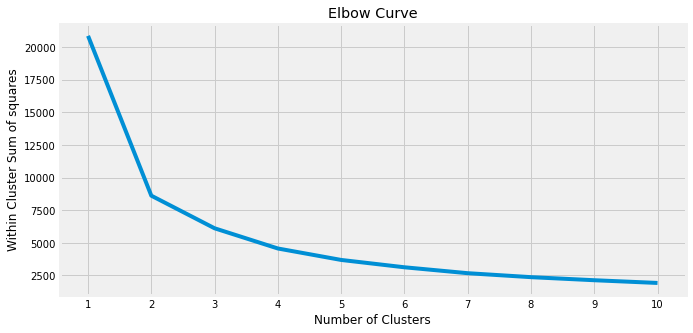

In [12]:
k = list(range(1,11))
sum_of_squared_distances = []
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.xticks(range(1, 11))
plt.plot(k, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of squares')
plt.title('Elbow Curve')
plt.show()

### Based on the Elbow method above, we'll pick 5 as the ideal number of clusters, given how the reduction in WCSS is minimal after that

In [13]:
kmeans_final = KMeans(n_clusters = 5)
kmeans_final.fit(scaled_df)
y_pred = kmeans_final.fit_predict(scaled_df)

In [14]:
df_kmeans['cluster'] = y_pred+1 #This is to start clusters with value 1 instead of 0 

### Plotting a scatterplot to see how the clusters are formed with respect to property area and rent amount

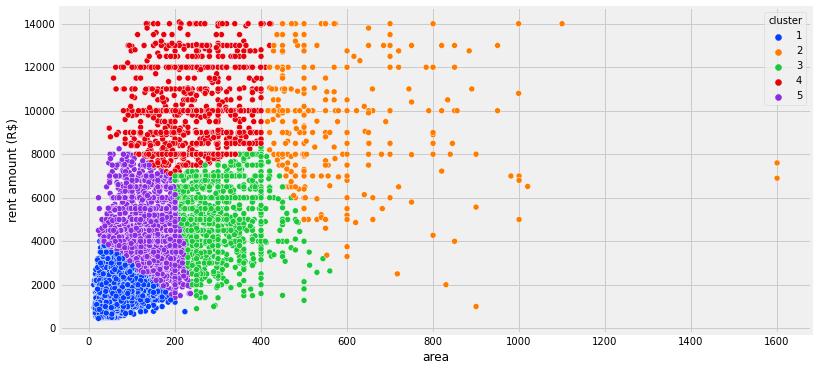

In [15]:
plt.figure(figsize=(12,6))
sns.set_palette("pastel")
sns.scatterplot(x=df_kmeans['area'], y = df_kmeans['rent amount (R$)'], hue=df_kmeans['cluster'], palette='bright')
plt.show()

### Given the plot above, it's up to the team involved in the creation of the model to use their domain knowledge to not only infer a possible nomenclature for the clusters, but also judge the appropriateness of the number of clusters

### ----------------------------------------------------------------------------------------------------------------------------------

# KNN

### KNN is supervised machine learning (ML) algorithm that can be used for classification or regression. It's based on the premise that the observations closest to a given data point are the most "similar" observations in a data set, which enables us to classify unforeseen data points based on the values of the surrounding existing points. K in this context refers to the number of nearest neighbor data points to use in the algorithm. 

In [16]:
df_knn = df.copy()

### Let's suppose that properties by design are bucketed into 5 groups based on a given criteria, and then we want to classify new properties as they enter our dataset, assigning them to one of the groups. In this case we're artificially creating 5 groups based on rent amount value

In [17]:
df_knn["rent amount (R$) group"] = pd.qcut(df_knn["rent amount (R$)"], 5, retbins=False, labels=['group 1','group 2','group 3','group 4','group 5'])

In [18]:
y = df_knn['rent amount (R$) group']
X = df_knn.drop(['rent amount (R$)', 'rent amount (R$) group'], axis = 1)

### We split our data into a training and test set, with the latter being a proxy for 'unseen' data, i.e., new properties that have no group label attached to them that are added to our dataset.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

### Scaling of the features

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Fitting our KNN model and making predictions on the test set

In [21]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Assigning group names and displaying both a heatmap with a confusion matrix and a classification report so that we can understand how well our groups are classified

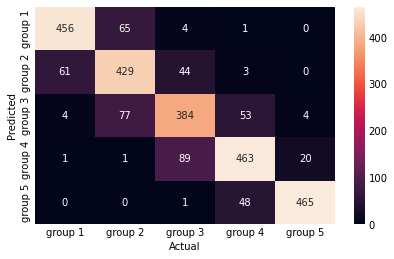

In [22]:
group_names = ['group 1','group 2','group 3','group 4','group 5']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=group_names, index = group_names)
                  
s = sns.heatmap(cm, annot=True, fmt='d')
s.set_xlabel('Actual', fontsize=10)
s.set_ylabel('Predicted', fontsize=10)
plt.show()


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     group 1       0.87      0.87      0.87       526
     group 2       0.75      0.80      0.77       537
     group 3       0.74      0.74      0.74       522
     group 4       0.82      0.81      0.81       574
     group 5       0.95      0.90      0.93       514

    accuracy                           0.82      2673
   macro avg       0.83      0.82      0.82      2673
weighted avg       0.82      0.82      0.82      2673



### Without getting into the details of the score metrics (later), there are two things that one should be aware of when building a KNN model: 

#### 1) Iterate through the number of bins (groups) to see how the model responds

#### 2) Iterate through the number of K neighbors (below)


In [24]:
# We'll limit ourselves to try K values from 1 to 20 and use the f1_score which is the harmonic mean of precision and recall. 
# The lowest f1-score value is 0 and the highest is 1. 
# When f1-score is equal to 1, it means all classes were correctly predicted.

from sklearn.metrics import f1_score

f1_scores = []

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, pred_i, average='weighted'))

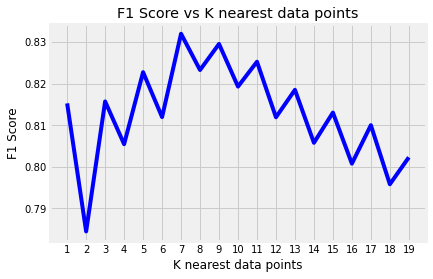

In [25]:
plt.plot(range(1, 20), f1_scores, color='blue',
         markerfacecolor='blue', markersize=5)
plt.xticks(range(1,20))
plt.title('F1 Score vs K nearest data points')
plt.xlabel('K nearest data points')
plt.ylabel('F1 Score')
plt.show()